In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tikzplotlib
import os

import scipy.stats as st

In [13]:
scratchHPC = r'U:\Results\HRC_60'

In [14]:
StudienOrdner = 'Volstudie_Strain_1/_diff_crit_source_eval'
StudienOrdner = os.path.join(scratchHPC, StudienOrdner)

In [15]:
lf_csv = r'_eval/lifetime.csv'
lf_csv = os.path.join(StudienOrdner, lf_csv)

In [16]:
df_lf = pd.read_csv(lf_csv)

In [17]:
ll_volf = df_lf['ModelName'].tolist()
ll_volf = [float(kk[kk.rfind('_')+15:])   for kk in ll_volf]

ll_Seed = df_lf['ModelName'].tolist()
ll_Seed = [str(kk[kk.find('_')+5:kk.find('Strain')-1])   for kk in ll_Seed]

In [18]:
minimia_vol = min(ll_volf)
maxima_vol = max(ll_volf)

In [19]:
df_lf['Volume_Martensite'] = ll_volf
df_lf['Seed'] = ll_Seed

df_wholMod = df_lf[df_lf['Phase']=='wholeMod']

In [20]:
norm = matplotlib.colors.Normalize(vmin=minimia_vol, vmax=maxima_vol, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm) 

In [21]:
from scipy import optimize

def tfunktion(x_data, a,b):
    return a*(x_data**2)+b*x_data+x_data


In [22]:
params, params_covariance = optimize.curve_fit(tfunktion, df_wholMod['Lifetime'].tolist(), df_wholMod['StrainAmplitude'].tolist(),)

In [23]:
colorswhole = df_wholMod['Volume_Martensite'].tolist()
un_voll = np.unique(colorswhole)
colorswhole = [float(c) for c in colorswhole]

strain_ll = np.unique(df_wholMod['StrainAmplitude'].tolist())

dic_f_curve = {}
for  vol in un_voll:
    df_red = df_wholMod[df_wholMod['Volume_Martensite']==vol]
    params, params_covariance = optimize.curve_fit(tfunktion, df_red['Lifetime'].tolist(), df_red['StrainAmplitude'].tolist())
    
    ll_mean_lifetimes = [np.min(df_red[df_red['StrainAmplitude']==stra]['Lifetime'].tolist()) for stra in strain_ll]
    print(ll_mean_lifetimes)
    f_curve = [tfunktion(lf, params[0], params[1]) for lf in ll_mean_lifetimes]
    dic_f_curve[vol] = f_curve

print(dic_f_curve)

[41717.18125983528, 2527.8813121965795, 653.9169657934561]
[40715.48947335145, 2574.3172748850634, 640.5086152670874]
[38913.95116317156, 2062.24643426014, 415.71153679846776]
[35548.199821374124, 1807.3668194118743, 434.0969962009513]
[30655.65719331252, 1809.5266330650904, 418.0852328330031]
[3201619.0558386245, 88822.11115326713, 23196.410853696038]
{75.0: [0.006603419402381405, 0.0007524490160903952, 0.00019900286724805483], 80.0: [0.002924810141848866, 0.00023664479522267357, 5.953133745606465e-05], 85.0: [0.0028389095095917583, 0.00018872039208872593, 3.838731976202325e-05], 90.0: [0.004718355936347507, 0.0003952125271098339, 9.644126100738504e-05], 95.0: [0.005900141033635009, 0.0005993243451030139, 0.00014126991339935557], 100.0: [-0.001469477079808712, -6.582050991710275e-05, -1.7327347450191155e-05]}


Text(0, 0.5, 'Strain')

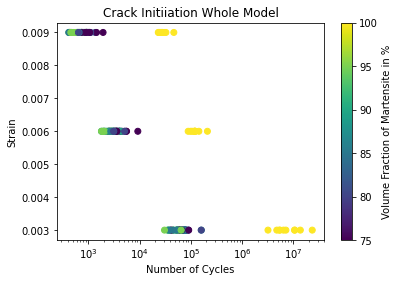

In [24]:

plt.scatter(df_wholMod['Lifetime'], df_wholMod['StrainAmplitude'], c=colorswhole)
cbar = plt.colorbar(mapper)
cbar.set_label('Volume Fraction of Martensite in %')
plt.xscale('log')
plt.title('Crack Initiiation Whole Model')
plt.xlabel('Number of Cycles')
plt.ylabel('Strain')
#plt.show()


#plt.savefig(os.path.join(StudienOrdner, 'ScatterLifetimeWholeMod.png'), bbox_inches='tight', dpi=150, transparent=True)

In [25]:
df_Ferrite = df_lf[df_lf['Phase']=='Ferrite']

In [26]:
colorsFerr = df_Ferrite['Volume_Martensite'].tolist()
colorsFerr = [float(c) for c in colorsFerr]

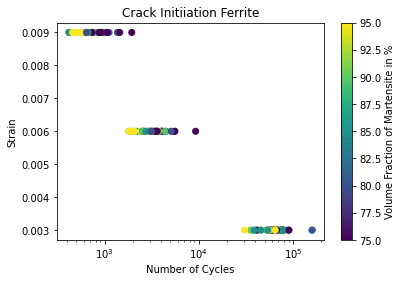

In [27]:
plt.scatter(df_Ferrite['Lifetime'], df_Ferrite['StrainAmplitude'], c=colorsFerr)
cbar = plt.colorbar()
cbar.set_label('Volume Fraction of Martensite in %')
plt.xscale('log')
plt.title('Crack Initiiation Ferrite')
plt.xlabel('Number of Cycles')
plt.ylabel('Strain')
plt.show()

In [28]:
df_mart = df_lf[df_lf['Phase']=='Martensite']

In [29]:
colorsMart = df_mart['Volume_Martensite'].tolist()
colorsMart = [int(c) for c in colorsMart]

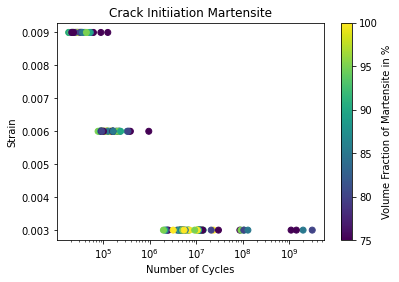

In [30]:
plt.scatter(df_mart['Lifetime'], df_mart['StrainAmplitude'], c=colorsMart)
cbar = plt.colorbar(mapper)
cbar.set_label('Volume Fraction of Martensite in %')
plt.xscale('log')
plt.title('Crack Initiiation Martensite')
plt.xlabel('Number of Cycles')
plt.ylabel('Strain')
plt.show()

Abwärts erstelle confidence intervalle

In [31]:
strainll = np.unique(df_wholMod['StrainAmplitude'].tolist())
dic_df_conf = {}
ch_df = {'whole': df_wholMod, 'Ferrite': df_Ferrite, 'Martensite': df_mart}
dd_ll = ['whole','Ferrite','Martensite']
for dd in dd_ll:
    df_conf = pd.DataFrame({'StrainAmplitude': strainll})
    for vols in np.unique(ll_volf):
        mean = []
        l_bound= []
        u_bound =  []
        for strain in strainll:
            rdf = ch_df[dd][ch_df[dd]['Volume_Martensite'] == vols]
            rdf = rdf[rdf['StrainAmplitude'] == strain]
            a = rdf['Lifetime'].tolist()
            if len(a) != 0:
                s_mean = np.mean(a)
                sl_bound, su_bound = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
                if sl_bound<0:
                    sl_bound = min(a)
            if len(a) == 0:
                s_mean,sl_bound, su_bound = np.NaN,np.NaN,np.NaN

            mean.append(s_mean), l_bound.append(sl_bound), u_bound.append(su_bound)
        df_conf['l_bound VolF '+ str(vols)] = l_bound
        df_conf['mean VolF '+ str(vols)] = mean
        df_conf['u_bound VolF '+ str(vols)] = u_bound
    dic_df_conf[dd] = df_conf

Plotten der confidence Intervalle

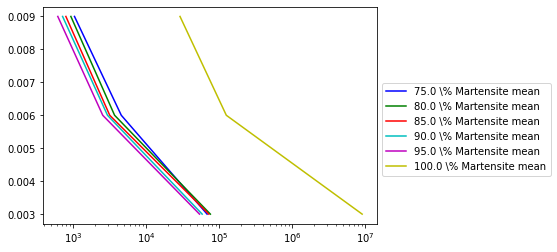

In [32]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']
df_conf = dic_df_conf['whole']

for num, vols in enumerate(np.unique(ll_volf)):

    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], label= (str(vols)+' \% Martensite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.legend(loc= 'lower left',bbox_to_anchor=(1.0, 0.2))#, ncol=2 )


plt.savefig(os.path.join(StudienOrdner, 'ConfLifetimeWholeMod.png'), bbox_inches='tight', dpi=150, transparent=True)

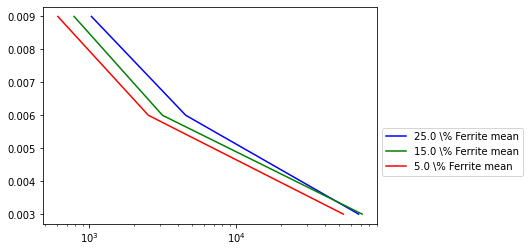

In [33]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']
df_conf = dic_df_conf['Ferrite']
volls_red = []
for num, vols in enumerate(np.unique(ll_volf)):
    if num%2 == 0:
        volls_red.append(vols)
    
for num, vols in enumerate(volls_red):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], label= (str(100-vols)+' \% Ferrite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.legend(loc= 'lower left',bbox_to_anchor=(1.0, 0.2))#, ncol=2 )


plt.savefig(os.path.join(StudienOrdner, 'ConfLifetimeFerrite.png'), bbox_inches='tight', dpi=150, transparent=True)

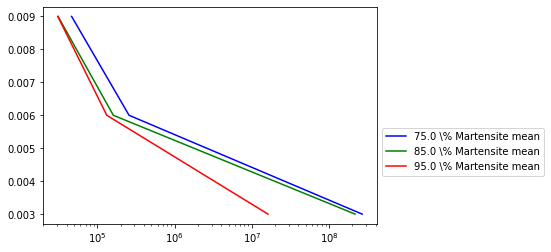

In [34]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']
df_conf = dic_df_conf['Martensite']
volls_red = []
for num, vols in enumerate(np.unique(ll_volf)):
    if num%2 == 0:
        volls_red.append(vols)
    
for num, vols in enumerate(volls_red):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], label= (str(vols)+' \% Martensite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.legend(loc = 'lower left',bbox_to_anchor=(1.0, 0.2))#, ncol=2 )


plt.savefig(os.path.join(StudienOrdner, 'ConfLifetimeMartensite.png'), bbox_inches='tight', dpi=150, transparent=True)

In [24]:
### AChtung lower bound ist nicht ganz korrekt das dieser durch die große varianz eine negative Lebensdauer angeben würde
### dacher ist in diesen Fällen der Lower Bound = minimum der Lebenszeit für definierte Dehnung und Volumengehalt

In [25]:
mnbv= df_lf[df_lf['StrainAmplitude']==0.009]
mnbv= mnbv[mnbv['Seed']=='93426']
mnbv[mnbv['Volume_Martensite'].isin([95.0,75.0])]

,Unnamed: 0,ModelName,ModelGroup,Lifetime,Phase,_LoadingMode,StrainAmplitude,StrainMean,StressAmplitude,StressMean,FIPmax,FIPmaxLocal,FIPcrit,m_FIP,IsExperimentalData,Volume_Martensite,Seed
30,10.0,DisTest_Seed93426_Strain0p9_VolumeFraction95,ALL,418.085233,wholeMod,0.0,0.009,0.0,1595.385,-0.035,0.076082,0.124378,2.52124,1.724138,0,95.0,93426
31,10.1,DisTest_Seed93426_Strain0p9_VolumeFraction95,ALL,33620.476477,Martensite,0.0,0.009,0.0,1595.385,-0.035,0.006098,0.013427,0.82424,2.124313,0,95.0,93426
32,10.2,DisTest_Seed93426_Strain0p9_VolumeFraction95,ALL,418.085233,Ferrite,0.0,0.009,0.0,1595.385,-0.035,0.076082,0.124378,2.52124,1.724138,0,95.0,93426
73,26.0,DisTest_Seed93426_Strain0p9_VolumeFraction75,ALL,1447.805034,wholeMod,0.0,0.009,0.0,1333.730,-0.180,0.037017,0.187961,2.52124,1.724138,0,75.0,93426
74,26.1,DisTest_Seed93426_Strain0p9_VolumeFraction75,ALL,1447.805034,Ferrite,0.0,0.009,0.0,1333.730,-0.180,0.037017,0.187961,2.52124,1.724138,0,75.0,93426
75,26.2,DisTest_Seed93426_Strain0p9_VolumeFraction75,ALL,61946.280666,Martensite,0.0,0.009,0.0,1333.730,-0.180,0.004574,0.014869,0.82424,2.124313,0,75.0,93426


Bestimme liegt geringste Lebenszeit immer mit Ferrit zusammen? 

In [26]:
#df_lf
ll_model = df_lf['Unnamed: 0'].tolist()

In [27]:
ll_prob_phase = []
for mod in ll_model:
    if mod%1 == 0:
        ltime = df_lf[df_lf['Unnamed: 0'] == mod]['Lifetime']
        
        phases = [g for g in ll_model if int(mod) == int(g) and g!=mod]
        
        for ph in phases:
            if float(df_lf[df_lf['Unnamed: 0'] == ph]['Lifetime']) == float(ltime):
                ll_prob_phase.append([len(phases),df_lf[df_lf['Unnamed: 0'] == ph]['Phase'].values[0]])        

print(np.unique(ll_prob_phase,axis=0))

[['1' 'Martensite']
 ['2' 'Ferrite']]


In [28]:
ll_prob_phase = []
for mod in ll_model:
    if mod%1 == 0:
        ltime = df_lf[df_lf['Unnamed: 0'] == mod]['Lifetime']
        
        phases = [g for g in ll_model if int(mod) == int(g) and g!=mod]
        ltime = 9e300
        phaseprob = ''
        for ph in phases:
            if float(df_lf[df_lf['Unnamed: 0'] == ph]['Lifetime']) < ltime:
                ltime = float(df_lf[df_lf['Unnamed: 0'] == ph]['Lifetime'])
                phaseprob = df_lf[df_lf['Unnamed: 0'] == ph]['Phase'].values[0]
        ll_prob_phase.append([len(phases),phaseprob])        

print(np.unique(ll_prob_phase,axis=0))

[['1' 'Martensite']
 ['2' 'Ferrite']]


In [29]:
strainll = np.unique(df_wholMod['StrainAmplitude'].tolist())
dic_df_StressAmp = {}
ch_df = {'whole': df_wholMod, 'Ferrite': df_Ferrite, 'Martensite': df_mart}
dd_ll = ['whole','Ferrite','Martensite']
for dd in dd_ll:
    df_conf = pd.DataFrame({'StrainAmplitude': strainll})
    for vols in np.unique(ll_volf):
        mean = []
        l_bound= []
        u_bound =  []
        for strain in strainll:
            rdf = ch_df[dd][ch_df[dd]['Volume_Martensite'] == vols]
            rdf = rdf[rdf['StrainAmplitude'] == strain]
            a = rdf['StressAmplitude'].tolist()
            if len(a) != 0:
                s_mean = np.mean(a)
                sl_bound, su_bound = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
                if sl_bound<0:
                    sl_bound = min(a)
            if len(a) == 0:
                s_mean,sl_bound, su_bound = np.NaN,np.NaN,np.NaN

            mean.append(s_mean), l_bound.append(sl_bound), u_bound.append(su_bound)
        df_conf['l_bound VolF '+ str(vols)] = l_bound
        df_conf['mean VolF '+ str(vols)] = mean
        df_conf['u_bound VolF '+ str(vols)] = u_bound
    dic_df_StressAmp[dd] = df_conf

Plotten confidence Intervalle bezogen auf Stress::

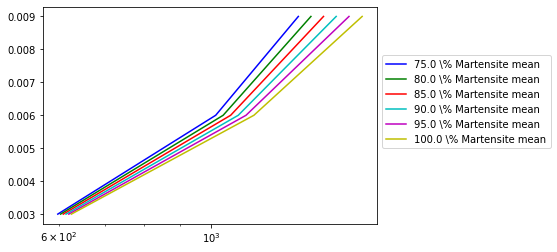

In [30]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']

df_conf = dic_df_StressAmp['whole']
for num, vols in enumerate(np.unique(ll_volf)):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], label= (str(vols)+' \% Martensite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.0, 0.8), ncol=1 )

#plt.savefig(os.path.join(StudienOrdner, 'StressAmplitude.png'), bbox_inches='tight', dpi=150, transparent=True)

In [36]:
df_conf

,StrainAmplitude,l_bound VolF 75.0,mean VolF 75.0,u_bound VolF 75.0,l_bound VolF 80.0,mean VolF 80.0,u_bound VolF 80.0,l_bound VolF 85.0,mean VolF 85.0,u_bound VolF 85.0,l_bound VolF 90.0,mean VolF 90.0,u_bound VolF 90.0,l_bound VolF 95.0,mean VolF 95.0,u_bound VolF 95.0,l_bound VolF 100.0,mean VolF 100.0,u_bound VolF 100.0
0,0.003,597.358805,597.89685,598.434895,602.960271,603.4456,603.930929,608.509463,609.01435,609.519237,614.059961,614.64785,615.235739,619.664959,620.40605,621.147141,625.320210,625.8033,626.286390
1,0.006,1013.479630,1016.18950,1018.899370,1039.756564,1041.9895,1044.222436,1066.717318,1068.57550,1070.433682,1094.632513,1096.21350,1097.794487,1123.468423,1125.16250,1126.856577,1154.470332,1155.3550,1156.239668
2,0.009,1335.684642,1341.36850,1347.052358,1394.812067,1399.3035,1403.794933,1456.208419,1459.65850,1463.108581,1520.394653,1523.18100,1525.967347,1587.246359,1590.09100,1592.935641,1660.758063,1662.0265,1663.294937
